In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sp
import csv
import autotime
import datetime
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

%matplotlib inline
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [24]:
data = pd.read_csv('weatherAUS.csv')
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [25]:
#Переопределение бинарных признаков
target = 'Yes'
data[['RainToday', 'RainTomorrow']] = data[['RainToday', 'RainTomorrow']].replace('No', 0)
data[['RainToday', 'RainTomorrow']] = data[['RainToday', 'RainTomorrow']].replace('Yes', 1)

In [26]:
print('Процент положительного предсказания: ', round(data['RainTomorrow'].value_counts(normalize=True)[1]*100,2), '%')
print('Процент отрицательного предсказания: ', round(data['RainTomorrow'].value_counts(normalize=True)[0]*100,2), '%')

Процент положительного предсказания:  22.42 %
Процент отрицательного предсказания:  77.58 %


In [27]:
#Заменяем дату прогноза на ко-во дней до текущей даты
#Есть ли более простой вариант обработки данного признака?
def date_to_days(data_dates):
    data_dates = data_dates.tolist()
    data_dates = np.asarray([day.split('-') for day in data_dates])
    past_time = [datetime.date(int(data_dates[i,0]), int(data_dates[i,1]), 
                               int(data_dates[i,2])) for i in range(data_dates.shape[0])]
    today_time = datetime.date.today()
    string_days_data = [(today_time - t) for t in past_time]
    days = (np.array([(str(t)).split()[0] for t in string_days_data])).astype('int64')
    return days
    
data['Date'] = date_to_days(data['Date'])

In [28]:
#Разделяем данные на количесвенные и категориальные и целевые значения
target_data = data['RainTomorrow']
numerical_data = (data[data.select_dtypes(exclude='O').columns]).drop('RainTomorrow', axis=1)
categorial_data = data[data.select_dtypes(include='O').columns]

In [29]:
#Обработка количественных признаков

In [30]:
#Заполняем пропуски средним значением в соответствии с каждым признаком кроме прогнозного Ra
for feature in numerical_data.columns:
    numerical_data[feature] = numerical_data[feature].fillna(numerical_data[feature].mean())

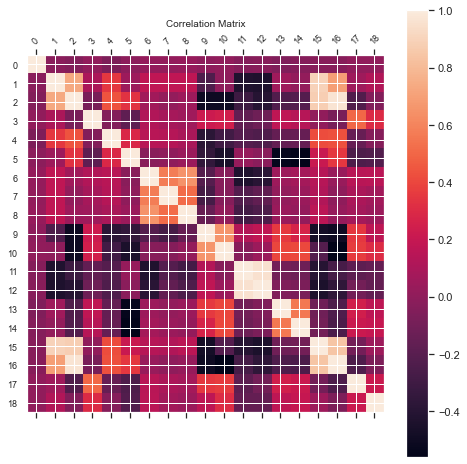

In [31]:
#Обработка количественных признаков
def plot_correlation_matrix(corr_mtrx):
    f = plt.figure(figsize=(8, 8))
    plt.matshow(corr_mtrx, fignum=f.number)
    plt.xticks(range(corr_mtrx.shape[1]), fontsize=9, rotation=45)
    plt.yticks(range(corr_mtrx.shape[1]), fontsize=9)
    cb = plt.colorbar()
    plt.title('Correlation Matrix', fontsize=10)

data_matrix = np.array(numerical_data)
corr_matrix = np.corrcoef(data_matrix.T)
plot_correlation_matrix(corr_matrix)

high_correlate_columns = np.unique([j for i in range(0, corr_matrix.shape[1]) for j in range(0,corr_matrix.shape[1]) 
     if ((i - j < 0) & (np.abs(corr_matrix[i,j]) > 0.5))])
numerical_data = numerical_data.drop(numerical_data.iloc[:,high_correlate_columns], axis=1)

In [32]:
#Обработка категориальных признаков

In [33]:
#Проверяем количество уникальных значений в каждом признаке
unique_values = pd.Series(index=categorial_data.columns)
for feature in categorial_data.columns:
    unique_values[feature] = len(categorial_data[feature].dropna().unique())

In [34]:
#Заполняем пропуски каждого признака соответствующим ему популярным значением
for feature in categorial_data.columns:
    categorial_data[feature] = categorial_data[feature].fillna(categorial_data[feature].value_counts().idxmax())

In [35]:
#Так как кол-во уникальных значений в каждом признаке достаточно большое, то применим Ordinary Encoding
OrdEnc = OrdinalEncoder()
OrdEnc.fit(categorial_data)
categorial_data[categorial_data.columns] = OrdEnc.transform(categorial_data)

In [36]:
#Объединяем обработанные количественные и категориальные признаки в один dataset
parsed_data = pd.concat([numerical_data, categorial_data], axis=1)
parsed_data.head()

,Date,MinTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,Humidity9am,Pressure9am,RISK_MM,Location,WindGustDir,WindDir9am,WindDir3pm
0,4501,13.4,0.6,5.469824,7.624853,44.0,71.0,1007.7,0.0,2.0,13.0,13.0,14.0
1,4500,7.4,0.0,5.469824,7.624853,44.0,44.0,1010.6,0.0,2.0,14.0,6.0,15.0
2,4499,12.9,0.0,5.469824,7.624853,46.0,38.0,1007.6,0.0,2.0,15.0,13.0,15.0
3,4498,9.2,0.0,5.469824,7.624853,24.0,45.0,1017.6,1.0,2.0,4.0,9.0,0.0
4,4497,17.5,1.0,5.469824,7.624853,41.0,82.0,1010.8,0.2,2.0,13.0,1.0,7.0


In [42]:
#Разделяем обработанные данные на train и test
X_train, X_test, Y_train, Y_test = train_test_split(parsed_data, target_data, test_size=0.25, random_state=42)

In [43]:
def metrics_values(test, predict):
    return np.array([accuracy_score(test, predict), precision_score(test, predict), 
                     recall_score(test, predict), f1_score(test, predict), roc_auc_score(test, predict)])

In [50]:
%%time 
#Метод k ближайших соседей
KNN = KNeighborsClassifier(n_neighbors=1)
KNN.fit(X_train, Y_train)
Y_pred = KNN.predict(X_test)
KNN_metrics = np.round(metrics_values(Y_test, Y_pred), 5)

Wall time: 3.57 s


In [46]:
params = {'n_neighbors': np.arange(1,11)}

KNN = KNeighborsClassifier()
clf_grid = GridSearchCV(KNN, params, scoring='recall', refit=True)
clf_grid.fit(X_train, Y_train)

# выведем наилучший гиперпараметр
print(clf_grid.best_params_)

{'n_neighbors': 1}


In [51]:
%%time
#Метод логистической регрессии
LogReg = LogisticRegression(C=3)
LogReg.fit(X_train, Y_train)
Y_pred = LogReg.predict(X_test)
LogReg_metrics = np.round(metrics_values(Y_test, Y_pred), 5)

Wall time: 692 ms


In [63]:
params = {'C': np.arange(1,11)}

LogReg = LogisticRegression()
clf_grid = GridSearchCV(LogReg, params, scoring='recall', refit=True)
clf_grid.fit(X_train, Y_train)

# выведем наилучший гиперпараметр
print(clf_grid.best_params_)

{'C': 3}


In [60]:
%%time
#Метод Байеса
Baies = GaussianNB(var_smoothing=1e-25)
Baies.fit(X_train, Y_train)
Y_pred = Baies.predict(X_test)
Baies_metrics = np.round(metrics_values(Y_test, Y_pred), 5)

Wall time: 78.1 ms


In [59]:
params = {'var_smoothing': np.arange(1e-25,1e-15,1)}

Baies = GaussianNB()
clf_grid = GridSearchCV(Baies, params, scoring='recall', refit=True)
clf_grid.fit(X_train, Y_train)

# выведем наилучший гиперпараметр
print(clf_grid.best_params_)

{'var_smoothing': 1e-25}


In [61]:
results_table = pd.DataFrame({'К ближайших соседей': KNN_metrics, 
                              'Логистическая регрессия': LogReg_metrics, 
                              'Наивный Байесовский классификатор': Baies_metrics}, 
                             index=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
results_table

,К ближайших соседей,Логистическая регрессия,Наивный Байесовский классификатор
accuracy,0.83873,0.95575,0.96664
precision,0.65875,0.91334,0.86984
recall,0.57406,0.88557,1.00000
f1,0.61350,0.89924,0.93039
roc_auc,0.74437,0.93073,0.97853
